In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._20220729_00 import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
# tb_unit1 = pd.read_csv(
#     os.path.join("tables", "tb_unit1.csv")
# )
# tb_unit2 = pd.read_csv(
#     os.path.join("tables", "tb_unit2.csv")
# )

# c22c1 = {}
# for _, row in tb_unit2.iterrows():
#     c2 = row["name"]
#     c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
#     c22c1[c2] = c1

# c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
for d in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    print(np.mean(
        (dataset.df[dataset.df["difficulty_cd"] == d]["isCorrect"] == "Y")
    ))

0.7904838691615995
0.7552252670692058
0.6944927770808886
0.6198139874167958
0.5103425450934966
0.4094488188976378
0.09523809523809523


In [5]:
for d in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    print(np.mean(
        (dataset.df[dataset.df["difficulty_cd"] == d]["isCorrect"] == "Y") & \
        (dataset.df[dataset.df["difficulty_cd"] == d]["duration"] <= dataset.difficulty2duration[d])
    ))

0.660754078901692
0.6280503054771518
0.5596750698013191
0.4650770493298076
0.3868939268575211
0.3543307086614173
0.09523809523809523


In [6]:
difficulty2duration = {
    1.0: 1.5,
    2.0: 2.0,
    3.0: 2.5,
    4.0: 2.5,
    5.0: 3.0,
    6.0: 5.0,
    7.0: 7.0,
}
for d in [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]:
    print(np.mean(
        (dataset.df[dataset.df["difficulty_cd"] == d]["isCorrect"] == "Y") & \
        (dataset.df[dataset.df["difficulty_cd"] == d]["duration"] <= difficulty2duration[d] * 60)
    ))

0.660754078901692
0.6280503054771518
0.5596750698013191
0.4650770493298076
0.3868939268575211
0.3543307086614173
0.09523809523809523


In [7]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220729_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [60]:
####################################################################

c3_seq = np.array([[0] * 3])
d_seq = np.array([[4, 6, 7]]) - 1
r_seq = np.array([[1, 1, 0]])

####################################################################

alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]

gamma_seq = model.D(LongTensor(d_seq)).squeeze()

alpha_seq = alpha_seq.detach().cpu().numpy()
gamma_seq = gamma_seq.detach().cpu().numpy()

prev_alpha = alpha_seq[0][:-1]
prev_alpha = np.concatenate([model.init_alpha(1).detach().cpu().numpy(), prev_alpha])

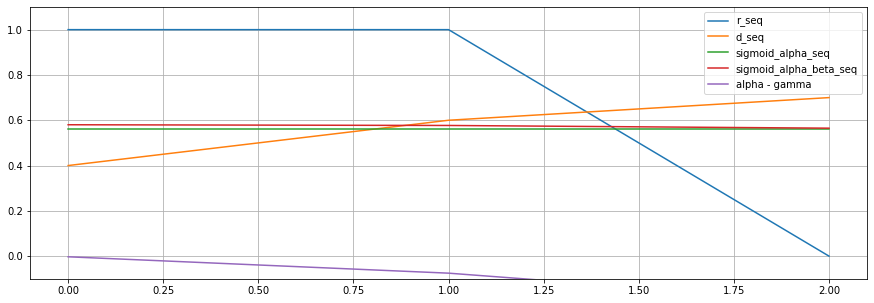

In [61]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.plot(CQ3_seq.T[0], label="sigmoid_alpha_beta_seq")
plt.plot(((prev_alpha - gamma_seq) / 10), label="alpha - gamma")
plt.grid()
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

In [62]:
sigmoid_alpha_seq

array([0.56176084, 0.56176084, 0.56176084], dtype=float32)

In [10]:
CQ3_seq.T.shape

(78, 7)

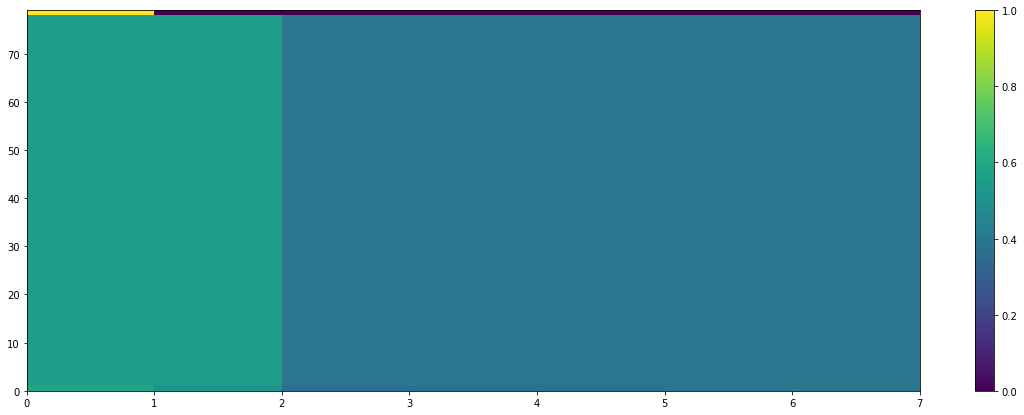

In [11]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ3_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [12]:
CQ3_seq[0][np.unique(c3_seq)], CQ3_seq[-1][np.unique(c3_seq)], np.unique(c3_seq), c3_seq, d_seq

(array([0.5867983], dtype=float32),
 array([0.39482906], dtype=float32),
 array([0]),
 array([[0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 1, 2, 3, 4, 5, 6]]))

In [13]:
from models.utils_02 import collate_fn

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=test_size, shuffle=True,
    collate_fn=collate_fn
)

alphas = []
sigmoid_alphas = []

logits = []
preds = []
tgts = []

for data in train_loader:
    c3_seq, d_seq, r_seq, \
        c3shft_seq, dshft_seq, rshft_seq, \
        m_seq = data

    batch_size = c3_seq.shape[0]
    seq_len = c3_seq.shape[1]

    # rshft_seq: [batch_size, seq_len]
    # m_seq: [batch_size, seq_len]

    alpha_seq, h_seq, C3_seq = \
        model(c3_seq, d_seq, r_seq)

    # alpha_seq: [batch_size, seq_len]

    # beta3_shft_seq: [batch_size, seq_len]
    beta3_shft_seq = torch.gather(
        C3_seq, dim=-1, index=c3shft_seq.unsqueeze(-1)
    ).reshape([batch_size, seq_len])

    # gamma_shft_seq: [batch_size, seq_len]
    gamma_shft_seq = model.D(dshft_seq).squeeze()
    
    alphas.append(
        torch.masked_select(
            alpha_seq, m_seq
        )
    )
    sigmoid_alphas.append(
        torch.sigmoid(torch.masked_select(
            alpha_seq, m_seq
        ))
    )
    
    c3_logits = \
        alpha_seq + \
        beta3_shft_seq - \
        gamma_shft_seq
    pred = torch.sigmoid(c3_logits)
    
    tgt = torch.masked_select(
        r_seq, m_seq
    )
    
    logits.append(c3_logits)
    preds.append(pred)
    tgts.append(tgt)

alphas = torch.cat(alphas, dim=0).detach().cpu().numpy()
sigmoid_alphas = torch.cat(sigmoid_alphas, dim=0).detach().cpu().numpy()

logits = torch.cat(logits, dim=0).detach().cpu().numpy()
preds = torch.cat(preds, dim=0).detach().cpu().numpy()
tgts = torch.cat(tgts, dim=0).detach().cpu().numpy()

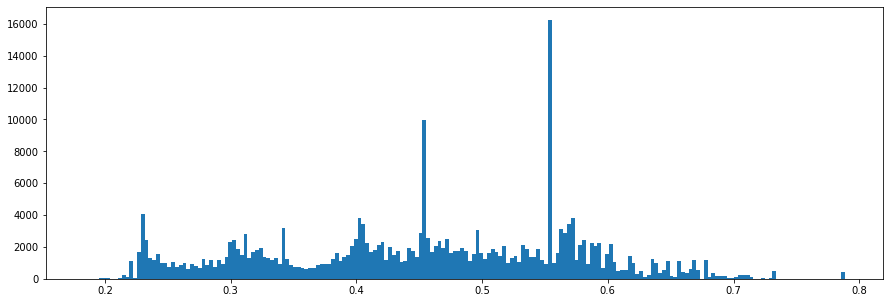

In [21]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.hist(sigmoid_alphas, bins=200)
plt.show()

In [83]:
def get_percentile_estimation()

array([0.55354136, 0.55354136, 0.55354136, ..., 0.47416502, 0.481071  ,
       0.481071  ], dtype=float32)

In [69]:
num_rep = 4

for c3_seq, d_seq, r_seq in [
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 0] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 6, 5] * num_rep]) - 1,
        np.array([[1, 0, 1] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 6, 5] * num_rep]) - 1,
        np.array([[1, 0, 0] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 2, 3] * num_rep]) - 1,
        np.array([[0, 1, 1] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 2, 3] * num_rep]) - 1,
        np.array([[0, 1, 0] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 2, 1] * num_rep]) - 1,
        np.array([[0, 0, 1] * num_rep]),
    ),
    (
        np.array([[0] * 3 * num_rep]),
        np.array([[4, 2, 1] * num_rep]) - 1,
        np.array([[0, 0, 0] * num_rep]),
    ),
]:
    alpha_seq, h_seq, C3_seq = model(
        LongTensor(c3_seq),
        LongTensor(d_seq),
        LongTensor(r_seq),
    )
    
    sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

    CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
    CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]
    
    sigmoid_alpha = sigmoid_alpha_seq[-1]
    sigmoid_alpha_beta = CQ3_seq[-1][0]
    
    print(
        "{}, {}, {}, {}".format(
            sigmoid_alpha,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha),
            sigmoid_alpha_beta,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha_beta)
        )
    )

0.6984632611274719, 0.9919648370218712, 0.7010719180107117, 0.9922248220727308
0.5714671015739441, 0.8423434402521854, 0.5747274160385132, 0.8548470962919632
0.5832164883613586, 0.8746343960222287, 0.5958849787712097, 0.9049754639108252
0.5617608428001404, 0.7999252542978779, 0.5475240349769592, 0.7136752136752137
0.553541362285614, 0.7227259432582627, 0.5854774117469788, 0.8778110883624192
0.39125826954841614, 0.2946727438172305, 0.36387863755226135, 0.25590653537421604
0.3102284073829651, 0.15767280881349321, 0.32353371381759644, 0.19163741834844494
0.2297893911600113, 0.01680153391180006, 0.1916140764951706, 3.249813135741686e-05


In [73]:
num_rep = 3

for c3_seq, d_seq, r_seq in [
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 1, 1, 1] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 1, 1, 0] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 1, 0, 0] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 1, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 1, 0, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 1, 0, 0, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[1, 0, 0, 0, 0, 0, 0] * num_rep]),
    ),
    (
        np.array([[0] * 7 * num_rep]),
        np.array([[1, 2, 3, 4, 5, 6, 7] * num_rep]) - 1,
        np.array([[0, 0, 0, 0, 0, 0, 0] * num_rep]),
    ),
]:
    alpha_seq, h_seq, C3_seq = model(
        LongTensor(c3_seq),
        LongTensor(d_seq),
        LongTensor(r_seq),
    )
    
    sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

    CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
    CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]
    
    sigmoid_alpha = sigmoid_alpha_seq[-1]
    sigmoid_alpha_beta = CQ3_seq[-1][0]
    
    print(
        "{}, {}, {}, {}".format(
            sigmoid_alpha,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha),
            sigmoid_alpha_beta,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha_beta)
        )
    )

0.7216244339942932, 0.9960636638393292, 0.7241336107254028, 0.9961408469013032
0.6654582619667053, 0.9749195671248904, 0.6684331297874451, 0.9761057489194371
0.6274842023849487, 0.9447450521595009, 0.6303368806838989, 0.9461546586071301
0.6092215180397034, 0.9279028955835039, 0.6121276021003723, 0.9292881284326151
0.553541362285614, 0.7227259432582627, 0.5565601587295532, 0.7881162458158656
0.45409128069877625, 0.49414221182282014, 0.4571230411529541, 0.5043913099996751
0.3665081560611725, 0.2586323161418218, 0.369350790977478, 0.2615165252997953
0.21940375864505768, 0.0020880049397159484, 0.22150442004203796, 0.002916707289330911


In [81]:
torch.sigmoid(model.D.weight)

tensor([[0.2335],
        [0.3000],
        [0.3972],
        [0.5605],
        [0.6645],
        [0.7309],
        [0.9059]], grad_fn=<SigmoidBackward>)

In [82]:
for sigmoid_alpha in torch.sigmoid(model.D.weight).detach().cpu().numpy():
    print(
        "{}, {}".format(
            sigmoid_alpha,
            1 - np.mean(sigmoid_alphas >= sigmoid_alpha)
        )
    )

[0.23345503], 0.03747034545513628
[0.29999962], 0.12952536479152443
[0.3972151], 0.30837476845081413
[0.5605429], 0.7959686068051087
[0.66447735], 0.9735587078742972
[0.7309381], 0.9963480224887069
[0.9058743], 1.0


In [17]:
model.D.weight

Parameter containing:
tensor([[-1.1889],
        [-0.8473],
        [-0.4171],
        [ 0.2434],
        [ 0.6833],
        [ 0.9994],
        [ 2.2643]], requires_grad=True)

In [18]:
down = 30
print(70)
print(70 * (1 - down * 1.5 * 1 / 100))
print(35 * (1 - down * 1.5 * 2 / 100) + 35 * (1 - down * 0.75 / 100))
print(30 * (1 - down * 1.5 * 3 / 100) + 40 * (1 - down * 0.75 / 100))

70
38.5
30.625
20.499999999999996


In [19]:
up = 30
print(70)
print(70 * (1 + up * 1.5 * 1 / 100))
print(35 * (1 + up * 1.5 * 2 / 100) + 35 * (1 + up * 0.75 / 100))
print(30 * (1 + up * 1.5 * 3 / 100) + 40 * (1 + up * 0.75 / 100))

70
101.5
109.375
119.5
